In [102]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import svm
from sklearn import linear_model
import xgboost as xgb
import matplotlib.ticker
from sklearn import metrics
from sklearn import preprocessing

from sklearn.metrics import make_scorer, r2_score, explained_variance_score, mean_absolute_error, mean_squared_error 
matplotlib.rcParams.update({'font.size': 16})

pd.options.display.max_columns = 100

In [61]:
df = pd.read_csv('data/eviction_with_unemployment_education_2005_2016.csv')
df.dropna(how = 'any', inplace = True)
df = df.drop(columns = df.columns[0], axis = 1)
df.reset_index(inplace = True)
df = df.rename(columns = {'name':'county', 'parent_location':'state'})

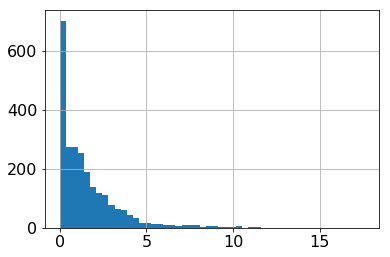

In [62]:
df_16 = df.loc[df.year == 2016, :]
df_16.loc[:,'eviction_rate'].hist(bins = 50)


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

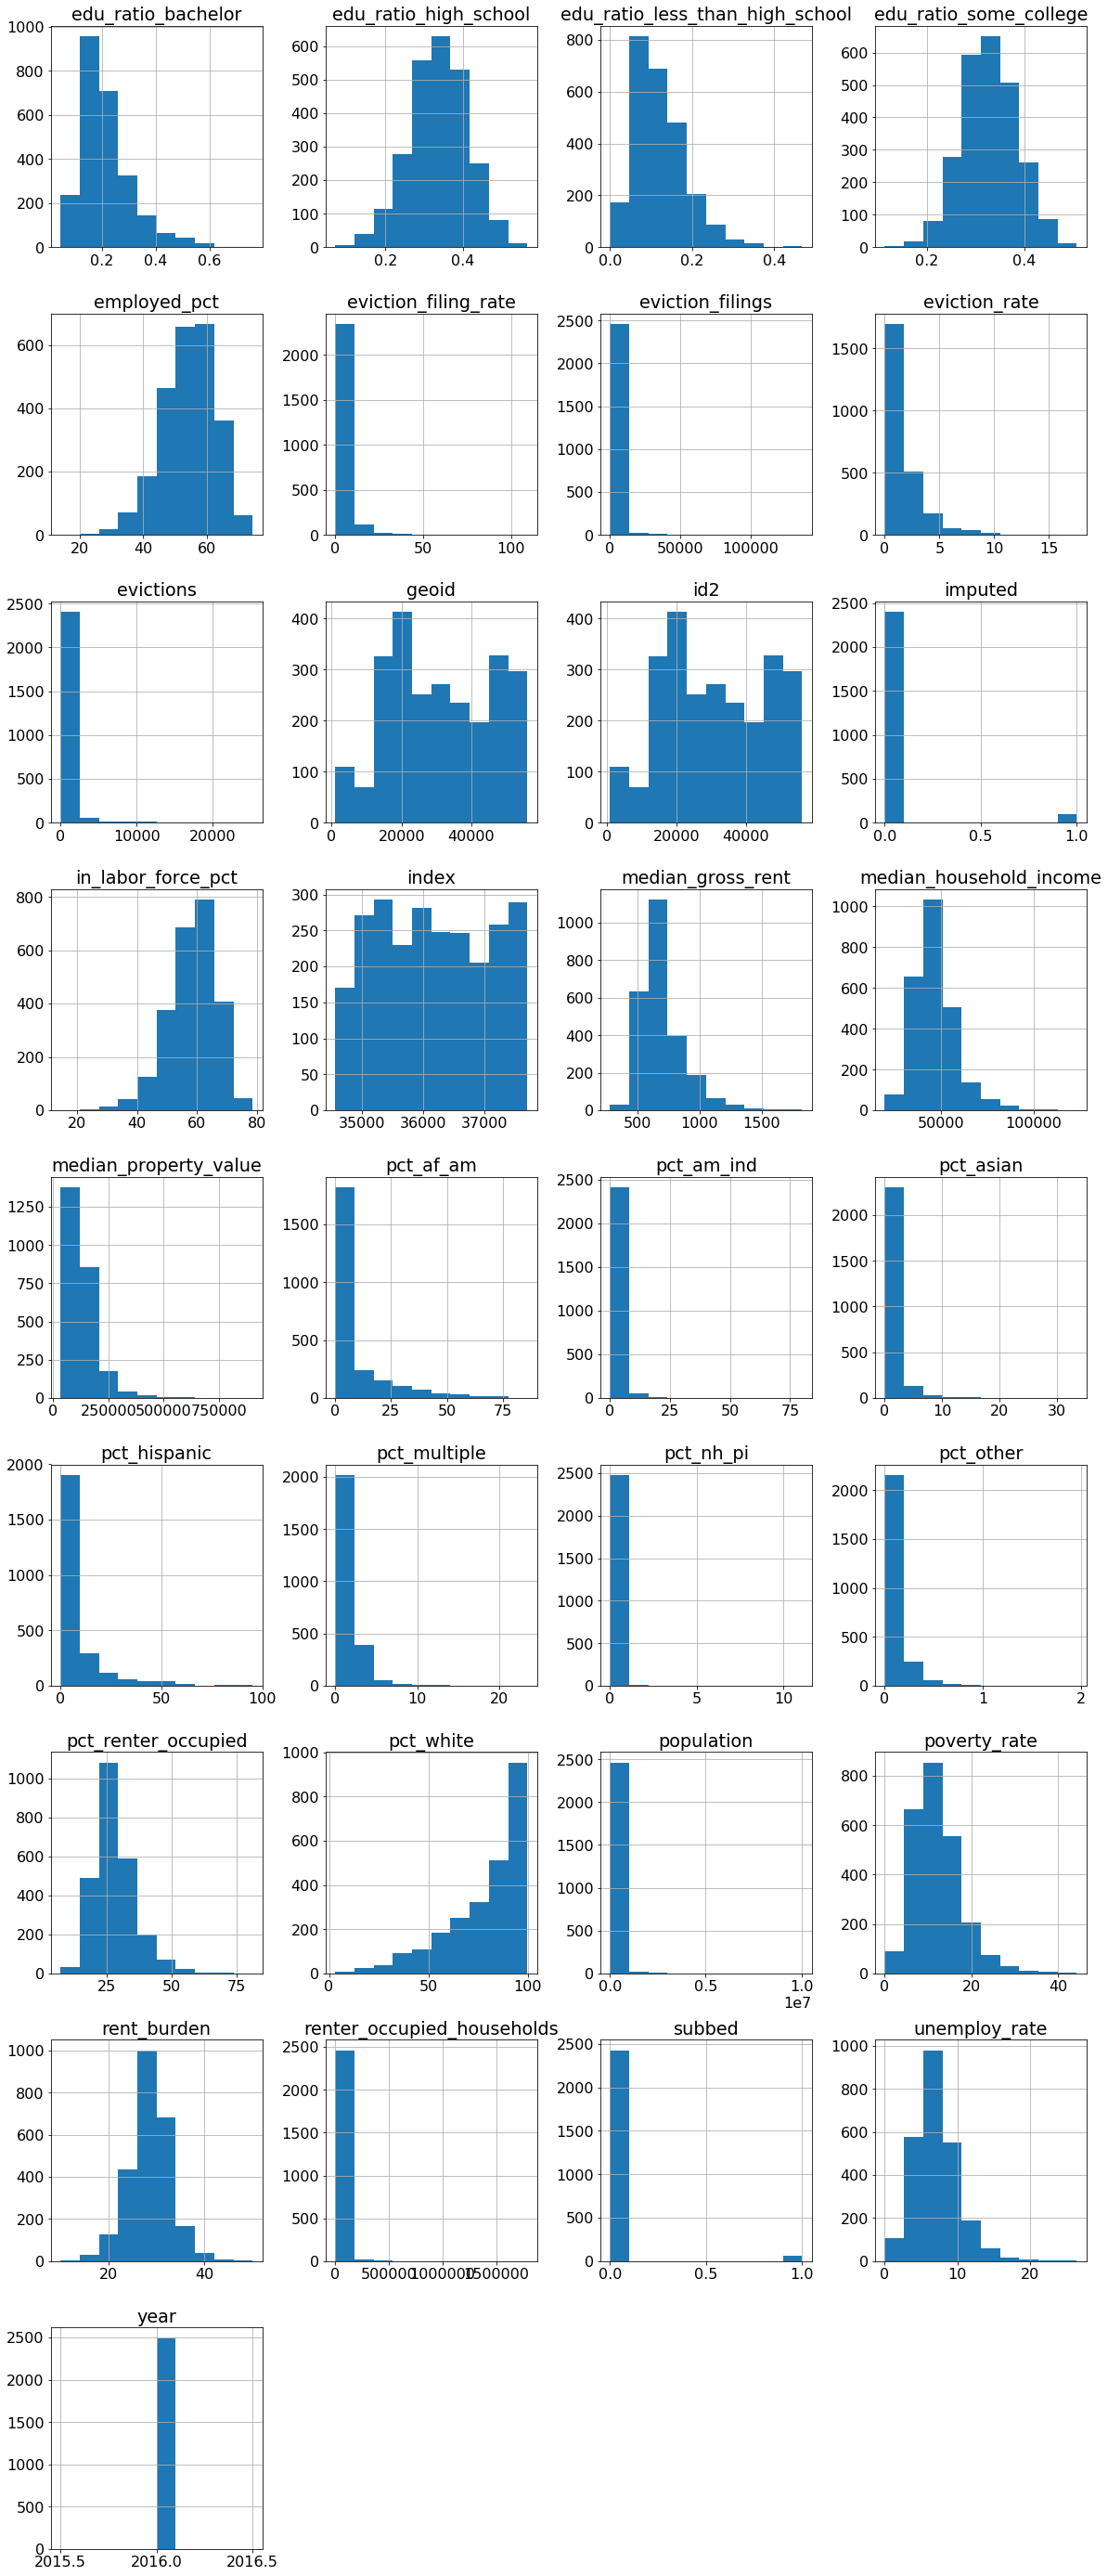

In [37]:
df_16.hist(figsize=(20,50), layout=(9,4))
plt.tight_layout

In [8]:
df_16.shape

(2493, 35)

In [6]:
list(df_16.columns)

['index',
 'geoid',
 'year',
 'county',
 'state',
 'population',
 'poverty_rate',
 'pct_renter_occupied',
 'median_gross_rent',
 'median_household_income',
 'median_property_value',
 'rent_burden',
 'pct_white',
 'pct_af_am',
 'pct_hispanic',
 'pct_am_ind',
 'pct_asian',
 'pct_nh_pi',
 'pct_multiple',
 'pct_other',
 'renter_occupied_households',
 'eviction_filings',
 'evictions',
 'eviction_rate',
 'eviction_filing_rate',
 'imputed',
 'subbed',
 'id2',
 'in_labor_force_pct',
 'employed_pct',
 'unemploy_rate',
 'edu_ratio_less_than_high_school',
 'edu_ratio_high_school',
 'edu_ratio_some_college',
 'edu_ratio_bachelor']

In [7]:
df_16.columns.get_loc('imputed')

25

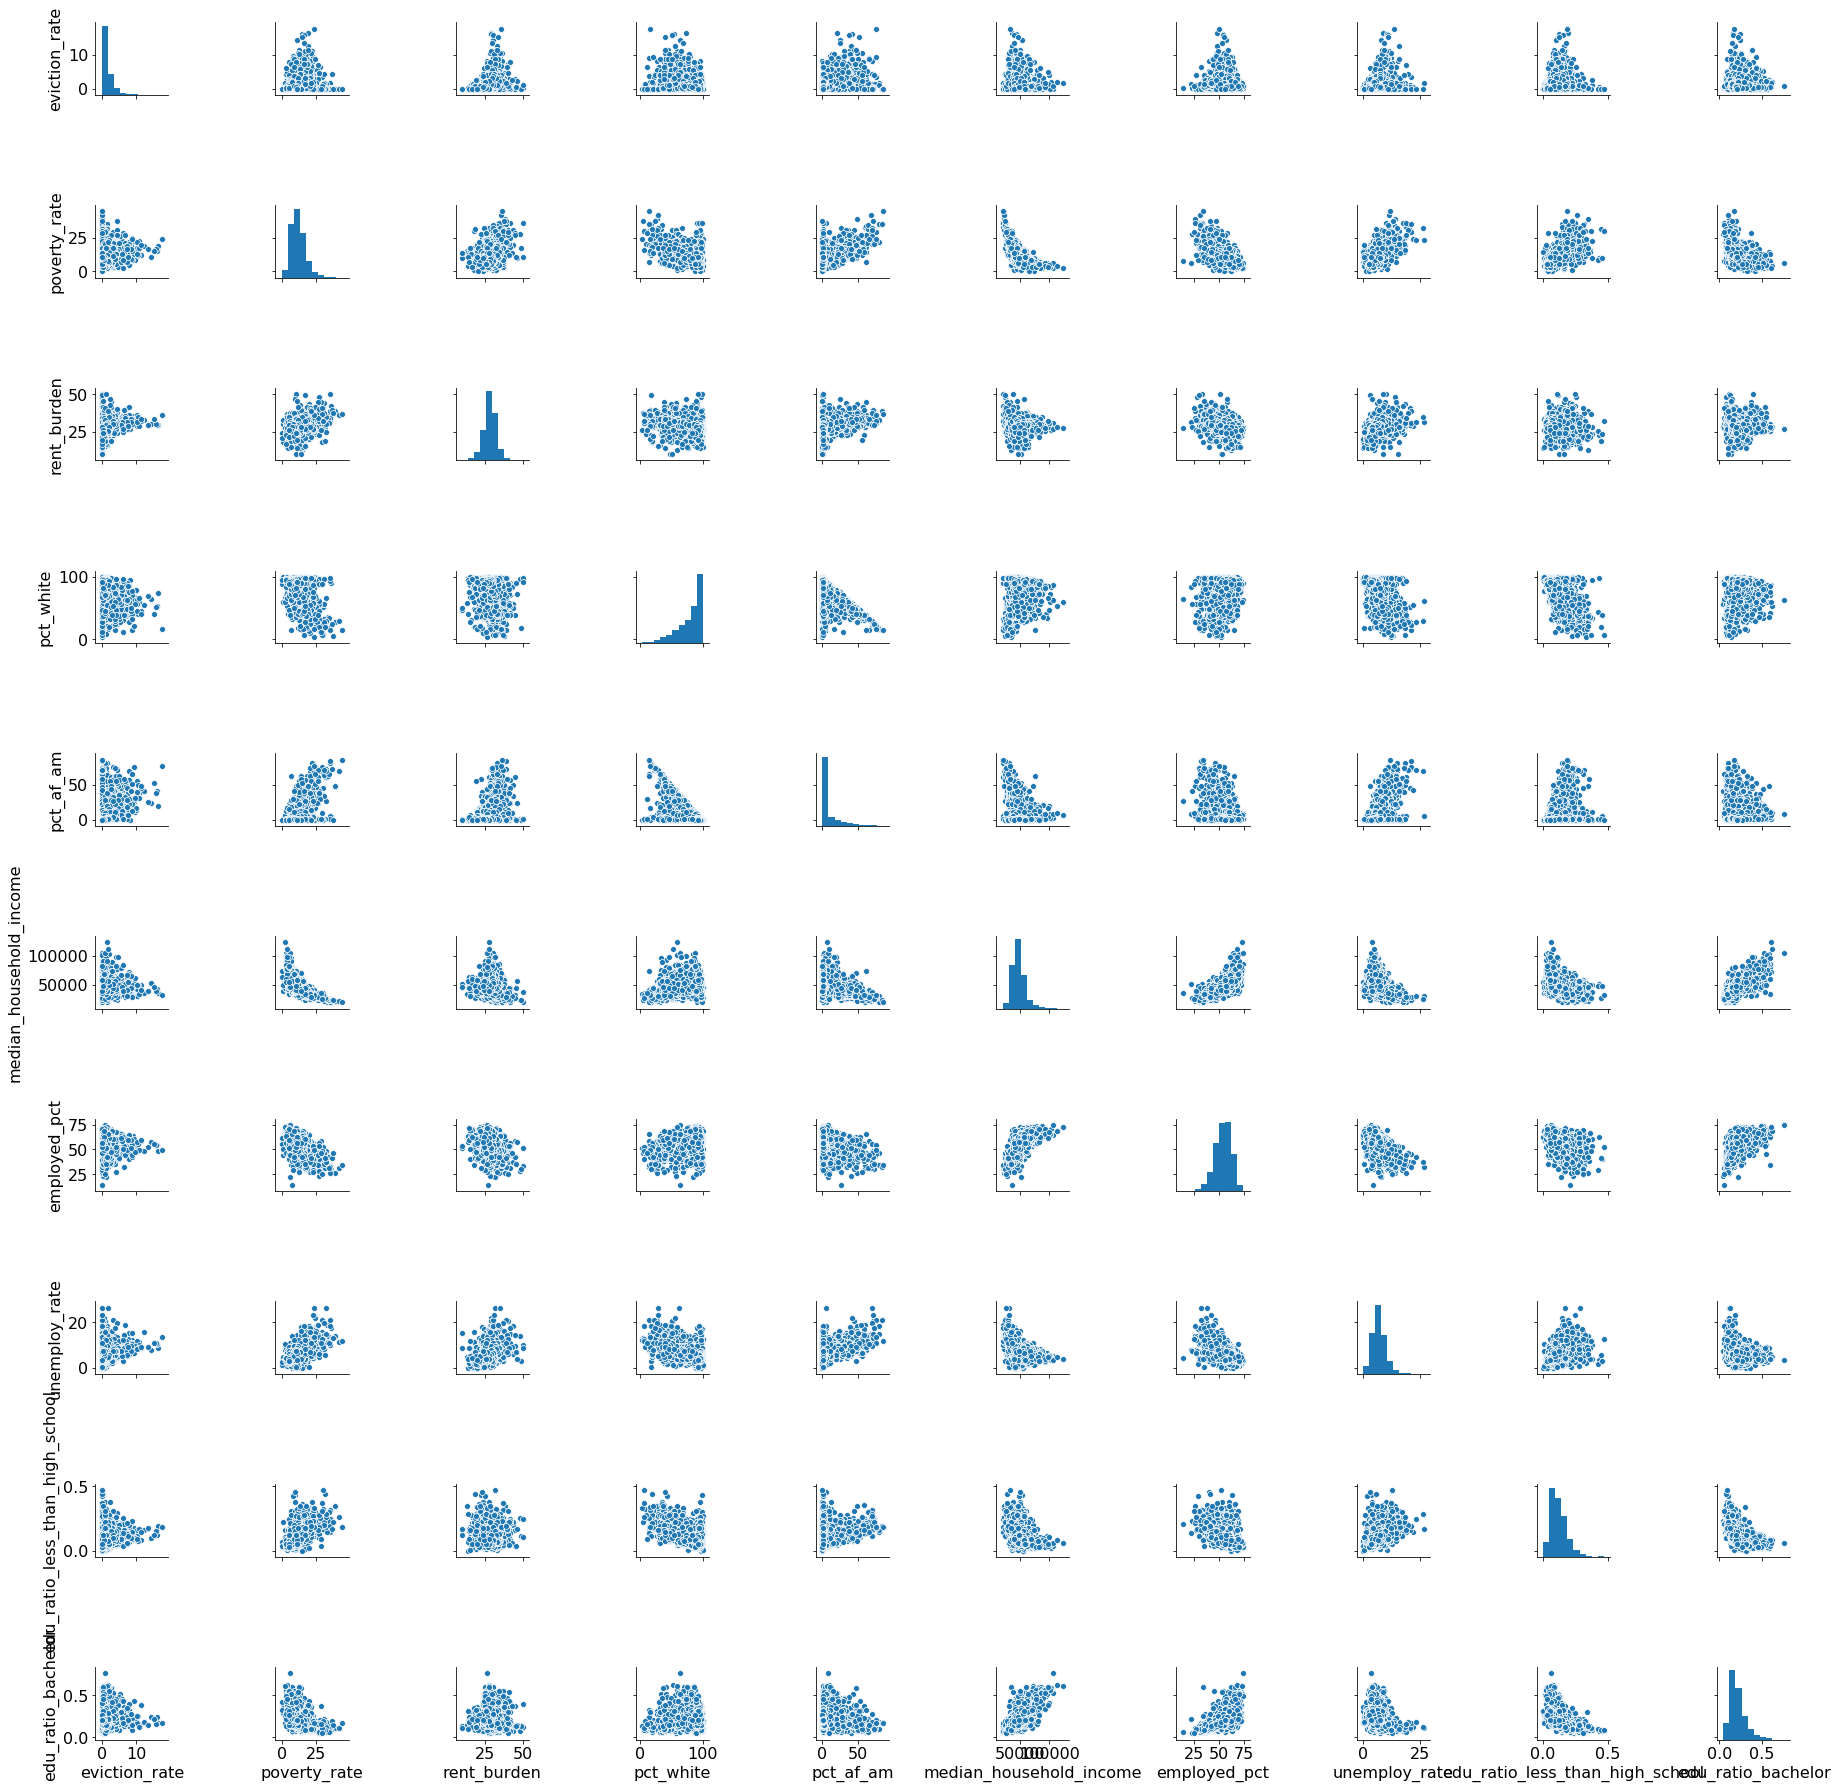

In [15]:
sns.pairplot(df_16, palette="husl", vars=['eviction_rate',"poverty_rate", 'rent_burden','pct_white',
 'pct_af_am','median_household_income',
 'employed_pct',
 'unemploy_rate',
 'edu_ratio_less_than_high_school',
 'edu_ratio_bachelor'])

In [63]:
corr = df_16.loc[:,['eviction_rate',"poverty_rate", 'rent_burden','pct_white',
 'pct_af_am','median_household_income',
 'employed_pct',
 'unemploy_rate',
 'edu_ratio_less_than_high_school',
 'edu_ratio_bachelor']].corr()

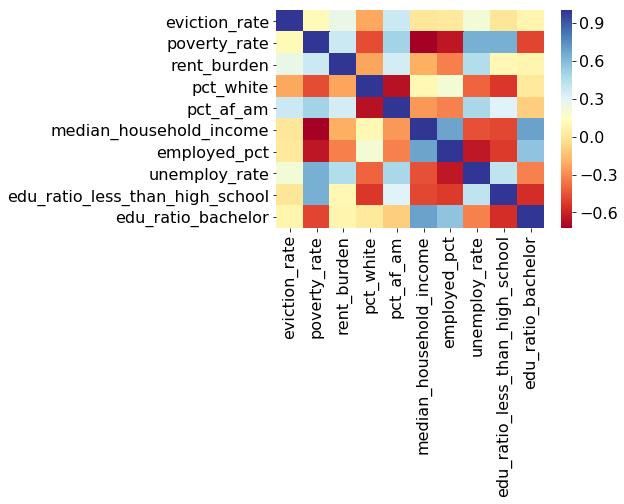

In [54]:
sns.heatmap(corr, cmap="RdYlBu")

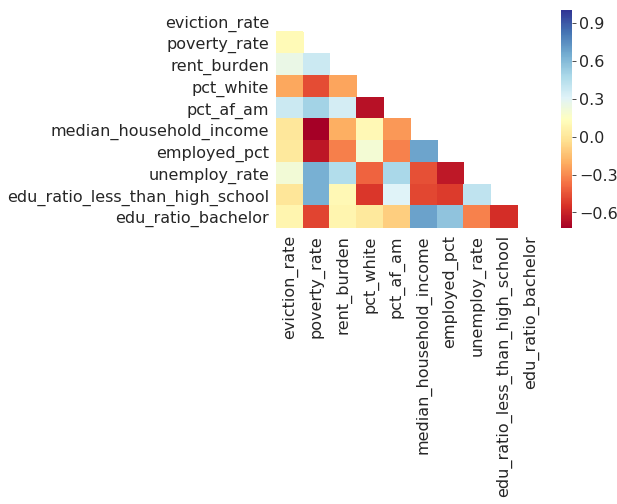

In [55]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
     ax = sns.heatmap(corr, mask=mask, cmap="RdYlBu")

# Eviction Rate with Features

## Poverty and Income

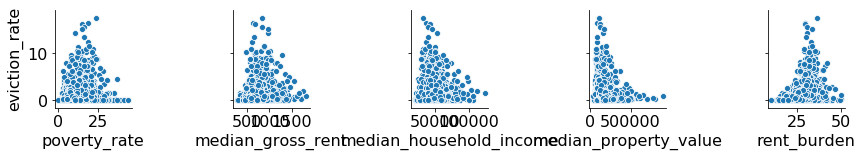

In [380]:
sns.pairplot(data=df_16, y_vars=['eviction_rate'],
                  x_vars=['poverty_rate', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'rent_burden'])

## Race

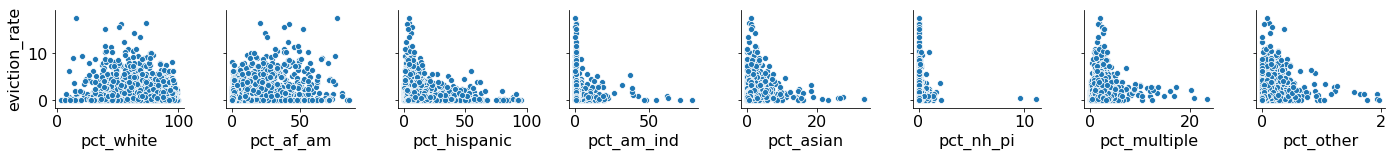

In [378]:
sns.pairplot(data=df_16, y_vars=['eviction_rate'],
                  x_vars=['pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian',
       'pct_nh_pi', 'pct_multiple', 'pct_other'])

## Education

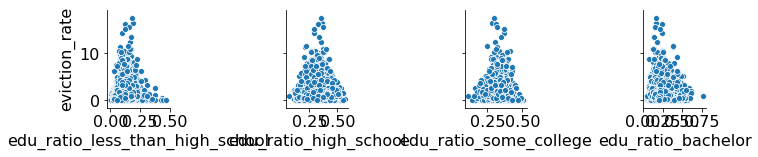

In [379]:
sns.pairplot(data=df_16, y_vars=['eviction_rate'],
                  x_vars=['edu_ratio_less_than_high_school', 'edu_ratio_high_school',
       'edu_ratio_some_college', 'edu_ratio_bachelor'])

## Employment

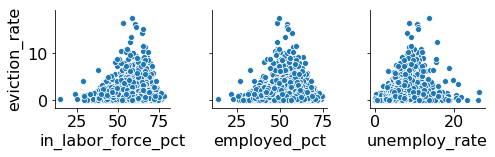

In [381]:
sns.pairplot(data=df_16, y_vars=['eviction_rate'],
                  x_vars=['in_labor_force_pct', 'employed_pct', 'unemploy_rate'])

## Renter housholds Number

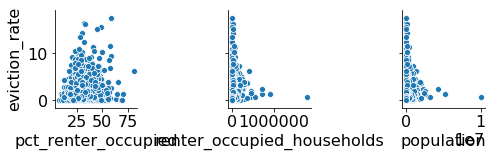

In [382]:
sns.pairplot(data=df_16, y_vars=['eviction_rate'],
                  x_vars=['pct_renter_occupied','renter_occupied_households','population'])

# feature selection

In [24]:
df.columns

Index(['index', 'geoid', 'year', 'county', 'state', 'population',
       'poverty_rate', 'pct_renter_occupied', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'rent_burden',
       'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian',
       'pct_nh_pi', 'pct_multiple', 'pct_other', 'renter_occupied_households',
       'eviction_filings', 'evictions', 'eviction_rate',
       'eviction_filing_rate', 'imputed', 'subbed', 'id2',
       'in_labor_force_pct', 'employed_pct', 'unemploy_rate',
       'edu_ratio_less_than_high_school', 'edu_ratio_high_school',
       'edu_ratio_some_college', 'edu_ratio_bachelor'],
      dtype='object')

In [115]:
df_dummy = pd.get_dummies(df[['state', 'year']])

In [116]:
df_dummy.head()

,year,state_Alabama,state_Arizona,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [117]:
df.shape

(29841, 35)

In [184]:
 col_list = ['poverty_rate', 'pct_renter_occupied', 'median_gross_rent',\
       'median_household_income', 'median_property_value', 'rent_burden',\
       'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian',\
       'pct_nh_pi', 'pct_multiple', 'pct_other', 'renter_occupied_households',\
       'in_labor_force_pct', 'employed_pct', 'unemploy_rate',
       'edu_ratio_less_than_high_school', 'edu_ratio_high_school',\
       'edu_ratio_some_college', 'edu_ratio_bachelor']

In [185]:
# col_list = ['poverty_rate','median_gross_rent','median_household_income',\
#             'median_property_value','pct_renter_occupied', 'rent_burden',\
#             'unemploy_rate', 'in_labor_force_pct', 'employed_pct',\
#             'edu_ratio_less_than_high_school', 'edu_ratio_high_school',\
#             'edu_ratio_some_college', 'edu_ratio_bachelor',\
#             'pct_white', 'pct_af_am','pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi',]

data_norm = preprocessing.normalize(df[col_list], axis = 0)

df_norm = pd.DataFrame(data_norm, columns = col_list)

In [186]:
X = pd.concat([df_norm, df_dummy], axis = 1)
y = df.eviction_rate

In [187]:
X.shape

(29841, 70)

In [188]:
y.shape

(29841,)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
#clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-5)
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)

## For comparison: Standard deviation 
std of a variable is basically the RMSE of an Ordinary least squares (OLS) model using only the mean as the predictor

In [192]:
y.std()

1.9857669438444097

In [193]:
y_train.std()

1.9802400257171777

In [194]:
y_test.std()

2.0077896433316145

## Prediction with Xgboost:

In [191]:
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values, y_test.values)
evallist = [(xgtrain, 'train'),(xgtest, 'eval'),]


In [369]:
param = {'silent': 1, 'max_depth': 5,'min_child_weight': 4,\
         'learning_rates': 0.05, 'alpha':1.5, 'lambda':0.5, 'objective':'reg:linear'}
num_boost_round = 100
bst = xgb.train(param, xgtrain, num_boost_round, evallist, early_stopping_rounds=10)

[0]	train-rmse:1.89568	eval-rmse:1.93278
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.6198	eval-rmse:1.65808
[2]	train-rmse:1.44753	eval-rmse:1.48853
[3]	train-rmse:1.34002	eval-rmse:1.37916
[4]	train-rmse:1.26218	eval-rmse:1.29781
[5]	train-rmse:1.21306	eval-rmse:1.24919
[6]	train-rmse:1.16853	eval-rmse:1.20946
[7]	train-rmse:1.134	eval-rmse:1.17627
[8]	train-rmse:1.11299	eval-rmse:1.1567
[9]	train-rmse:1.09266	eval-rmse:1.13962
[10]	train-rmse:1.08034	eval-rmse:1.12671
[11]	train-rmse:1.06934	eval-rmse:1.11613
[12]	train-rmse:1.05968	eval-rmse:1.10845
[13]	train-rmse:1.0504	eval-rmse:1.09685
[14]	train-rmse:1.04402	eval-rmse:1.09022
[15]	train-rmse:1.03554	eval-rmse:1.08111
[16]	train-rmse:1.02938	eval-rmse:1.07573
[17]	train-rmse:1.0236	eval-rmse:1.07039
[18]	train-rmse:1.0184	eval-rmse:1.06531
[19]	train-rmse:1.00891	eval-rmse:1.05728
[20]	train-rmse:0.9982	eval-rmse:1

In [370]:
X_dtest = xgb.DMatrix(X_test.values)
X_dtrain = xgb.DMatrix(X_train.values)
y_pred = bst.predict(X_dtest)
y_pred_train = bst.predict(X_dtrain)

print(" Evaluation of Training Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_train, y_pred_train), \
                                                                                                                explained_variance_score(y_train, y_pred_train),\
                                                                                                                mean_absolute_error(y_train, y_pred_train),\
                                                                                                                mean_squared_error(y_train, y_pred_train)))


print(" Evaluation of Test Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_test, y_pred), \
                                                                                                                explained_variance_score(y_test, y_pred),\
                                                                                                                mean_absolute_error(y_test, y_pred),\
                                                                                                                mean_squared_error(y_test, y_pred)))

 Evaluation of Training Set:
 r2_score	0.8688220270504388,
 explained_variance_score	0.8688220275607903,
 mean_absolute_error	0.4923189977581935,
 mean_squared_error	0.5143732695733073.

 Evaluation of Test Set:
 r2_score	0.8275108258601017,
 explained_variance_score	0.8275419896975352,
 mean_absolute_error	0.5621424665820921,
 mean_squared_error	0.6952251873758001.



# General Approach for Parameter Tuning
1.	Choose a relatively high learning rate.
Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.


2.	Tune tree-specific parameters 
( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. 
Note that we can choose different parameters to define a tree and I’ll take up an example here.


3.	Tune regularization parameters
(lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.


4.	Lower the learning rate and decide the optimal parameters .


'''
xgboost.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, 
early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)

xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1,
colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
random_state=0, seed=None, missing=None, **kwargs)¶
'''

## Hyper-parameter optimizers: GridSearchCV

In [ ]:
# # randomlize search cv
# model_xgb = xgb.XGBRegressor()
# param_dist = { 'max_depth': [5,6,7], 
#               'learning_rate': [0.4, 0.5, 0.6],
#               'gamma': [0.8,1,1.2],
#               'n_estimators':[20],
#               'objective': ['reg:linear', 'reg:linear regression'],
#               'booster':['gbtree','gblinear', 'dart']
#              }
# xgb_search = RandomizedSearchCV(model_xgb, param_dist)

In [353]:
model_xgb = xgb.XGBRegressor(max_depth = 5,  min_child_weight = 4, n_estimators=40,\
                             silent=True, objective='reg:linear', gamma = 1, \
                            booster='gbtree', subsample=1,colsample_bytree=1, \
                              reg_alpha = 1.5, reg_lamba = 0.5, \
                             base_score=0.1, random_state=0)

param_grid = {'learning_rate': [x/10 for x in range(1,5,1)]
             }
scorer = make_scorer(mean_squared_error)
xgb_search = GridSearchCV(estimator = model_xgb, param_grid = param_grid, cv=5, scoring=scorer)
xgb_search.fit(X_train,y_train)
y_pred = xgb_search.best_estimator_.predict(X_test)

In [354]:
xgb_search.best_params_ 

{'learning_rate': 0.1}

In [355]:
y_pred = xgb_search.best_estimator_.predict(X_test)
y_pred_train = xgb_search.best_estimator_.predict(X_train)

print(" Evaluation of Training Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_train, y_pred_train), \
                                                                                                                explained_variance_score(y_train, y_pred_train),\
                                                                                                                mean_absolute_error(y_train, y_pred_train),\
                                                                                                                mean_squared_error(y_train, y_pred_train)))


print(" Evaluation of Test Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_test, y_pred), \
                                                                                                                explained_variance_score(y_test, y_pred),\
                                                                                                                mean_absolute_error(y_test, y_pred),\
                                                                                                                mean_squared_error(y_test, y_pred)))

 Evaluation of Training Set:
 r2_score	0.7192067607021628,
 explained_variance_score	0.7193612957388293,
 mean_absolute_error	0.7232103076597036,
 mean_squared_error	1.1010426013157248.

 Evaluation of Test Set:
 r2_score	0.7064196107210305,
 explained_variance_score	0.7066198621731562,
 mean_absolute_error	0.7465587115535924,
 mean_squared_error	1.1832886450067397.



## Feature Importance

Text(0.5,1,'Feature Importances')

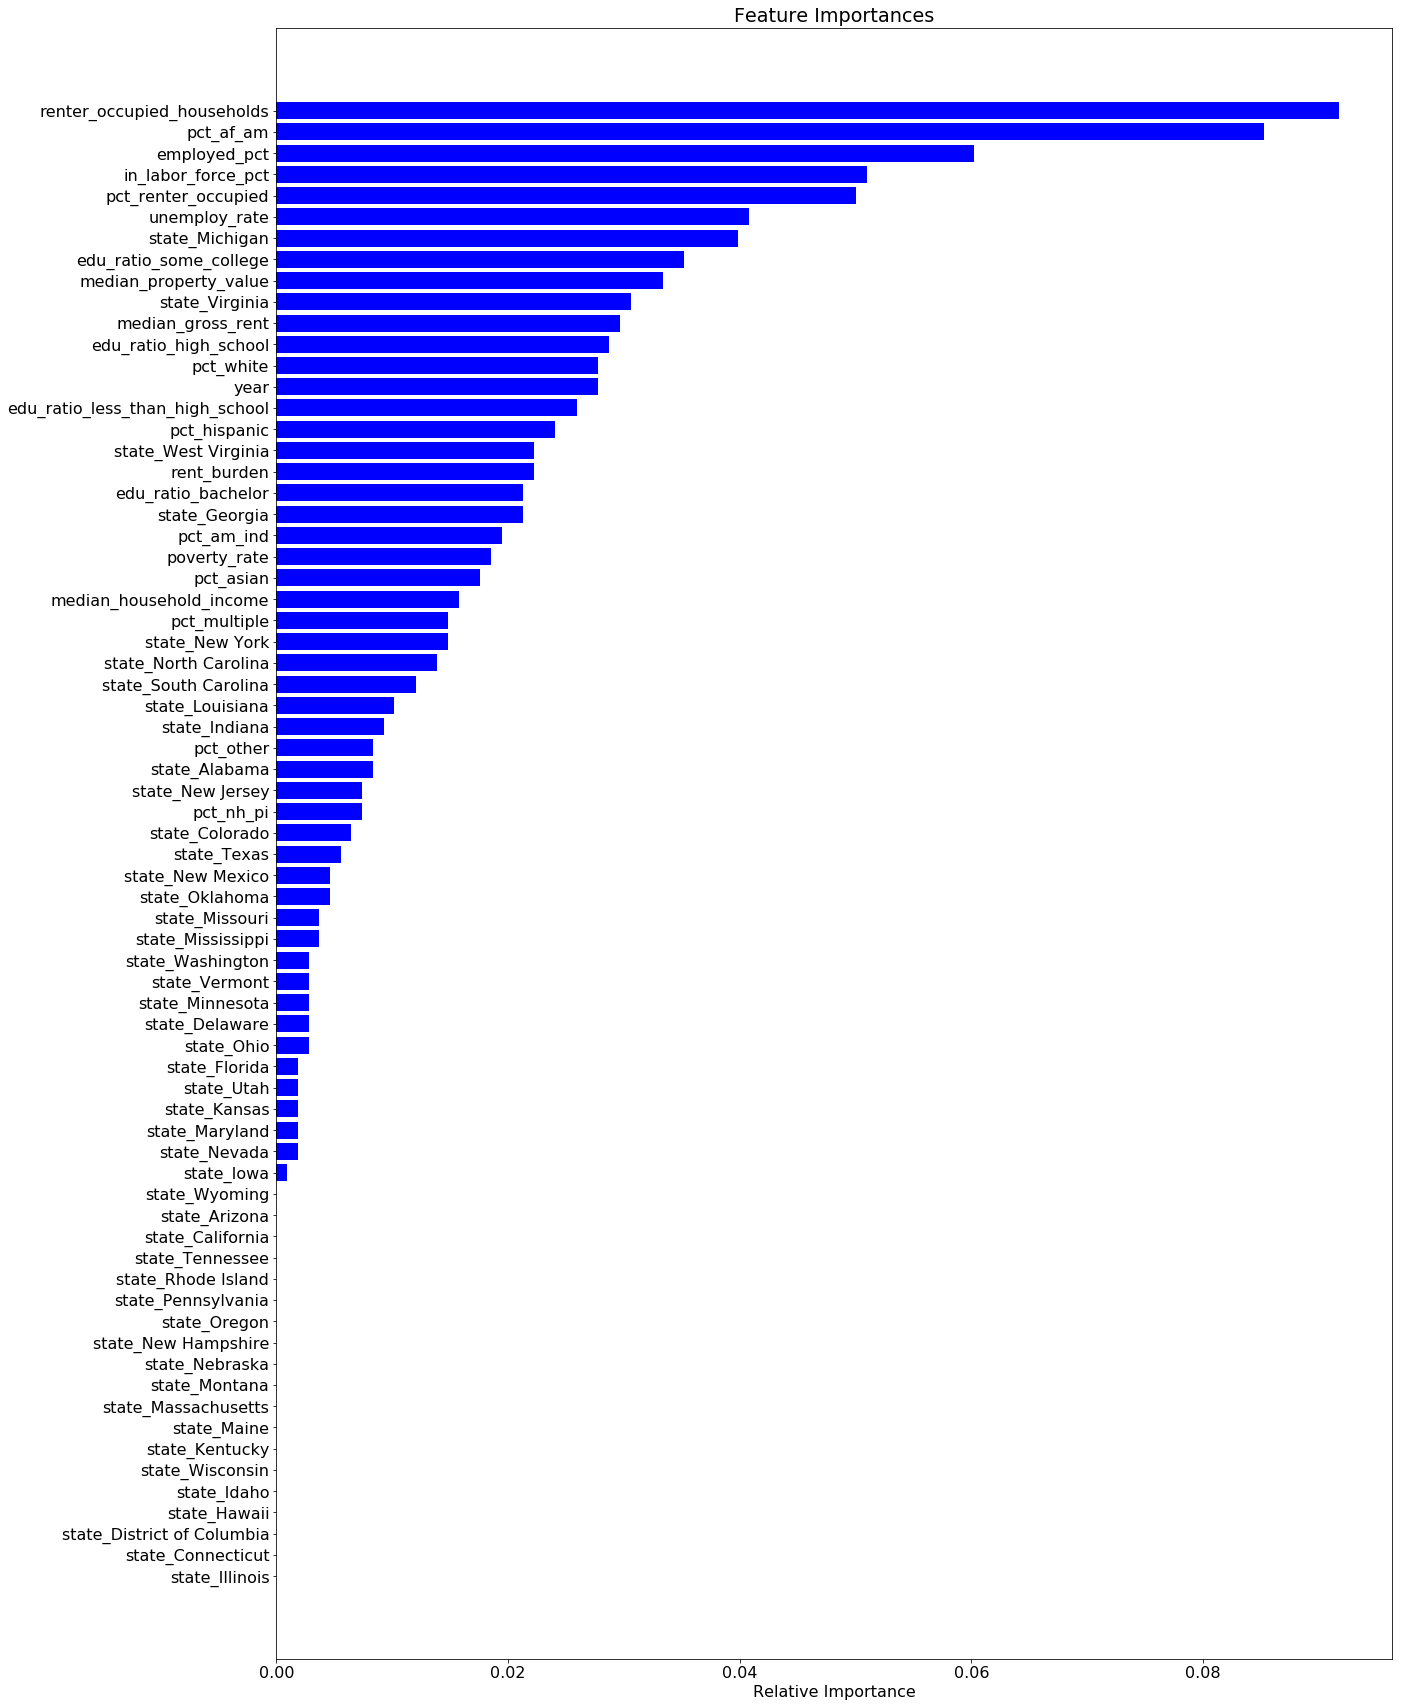

In [376]:
features = X.columns
importances = xgb_search.best_estimator_.feature_importances_
indices = np.argsort(importances)


plt.figure(figsize = (20,30))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importances')

## Prediction evaluation

In [373]:
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, gamma = 1, min_child_weight=4, \
                         reg_alpha = 1.5, reg_lambda = 0.5,n_estimators=400, silent=False, base_score = 0.1, \
                         subsample=1, colsample_bytree=1,
                         objective='reg:linear', booster='gbtree')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(" Evaluation of Training Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_train, y_pred_train), \
                                                                                                                explained_variance_score(y_train, y_pred_train),\
                                                                                                                mean_absolute_error(y_train, y_pred_train),\
                                                                                                                mean_squared_error(y_train, y_pred_train)))


print(" Evaluation of Test Set:\n r2_score\t{},\n explained_variance_score\t{},\n mean_absolute_error\t{},\n mean_squared_error\t{}.\n".format(r2_score(y_test, y_pred), \
                                                                                                                explained_variance_score(y_test, y_pred),\
                                                                                                                mean_absolute_error(y_test, y_pred),\
                                                                                                                mean_squared_error(y_test, y_pred)))

 Evaluation of Training Set:
 r2_score	0.8873270561003364,
 explained_variance_score	0.8873270587319377,
 mean_absolute_error	0.45269040890489315,
 mean_squared_error	0.4418116032971806.

 Evaluation of Test Set:
 r2_score	0.8401872155589771,
 explained_variance_score	0.8401895364595839,
 mean_absolute_error	0.5386858372039273,
 mean_squared_error	0.6441324422942942.

